#library

In [129]:
import os
import glob
import random
import math
import tensorflow
import numpy as np
import cv2
import imutils as im
import matplotlib.pyplot as plt
from sklearn import svm
from keras import layers
from keras import models
from skimage import feature
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.python import image
from keras.utils import to_categorical
# from keras_visualizer import visualizer 
from keras.layers.core.dense import Dense
from sklearn.metrics import accuracy_score
from keras.utils.vis_utils import plot_model
from tensorflow.python.ops.math_ops import add
from keras.engine.sequential import Sequential
from sklearn.preprocessing import LabelEncoder
from keras.layers.serialization import activation
from tensorflow.python.ops.math_ops import Sigmoid
from sklearn.model_selection import train_test_split
from keras.layers.convolutional.base_separable_conv import activations

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Part1.compatness

In [145]:
def find_contour(image):
  # convert to grayscale
  gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  i_copy = image.copy()

  
  # binarize 
  tresh, bi = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  bi = cv2.bitwise_not(bi)
  adaptive = cv2.bitwise_not(cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,15,6))
  kernel = cv2.getStructuringElement(
    cv2.MORPH_ELLIPSE,(3,3))
  bi = cv2.dilate(bi,kernel=kernel,borderType=cv2.BORDER_REPLICATE)
  bi = cv2.erode(bi,kernel=kernel,borderType=cv2.BORDER_REPLICATE)
  

  # find contours
  binary= bi
  cnts = cv2.findContours(binary.copy(), cv2.RETR_EXTERNAL,	cv2.CHAIN_APPROX_NONE)
  cnts = im.grab_contours(cnts)
  # print(cnts)

  max_i = 0
  m=0
  for i,c in enumerate(cnts):
    area=cv2.contourArea(c)
    if area>m:
      max_i=i
      m=area
  

  # draw contours
  # cv2.drawContours(i_copy, [cnts[max_i]], -1, (220, 25, 100), 3)

  # plt.figure()  
  # plt.imshow(i_copy,cmap='gray')
  return cnts[max_i]

  

In [120]:
def compatness(image):
  cnt = find_contour(image)
  area = cv2.contourArea(cnt)
  perimeter = cv2.arcLength(cnt, True)

  compactness_score = 4 * np.pi * area / (perimeter**2)

  return compactness_score

#Part2.eccenticity

In [161]:
def eccenticity(image):
  cnt = find_contour(image)

  (x,y),(MA,ma),angle = cv2.fitEllipse(cnt)
  eccentricity_score = np.sqrt(np.abs(1-(float(max(ma,0.01))/max(MA,0.1))**2))
  # print(ma,MA)
  return eccentricity_score

#Part3.solidity

In [122]:
def solidity(image):
  cnt = find_contour(image)
  area = cv2.contourArea(cnt)
  hull = cv2.convexHull(cnt)
  hull_area = cv2.contourArea(hull)
  solidity_score = float(area)/hull_area
  return  solidity_score


#Part4.LBP

In [134]:
# reference: https://pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/
def histogram_of_LBP(image, numPoints, radius, eps=1e-7):
	gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
	lbp=feature.local_binary_pattern(gray,P=numPoints,R=radius,method = 'default')
	# print(lbp.ravel())
	his, _ = np.histogram(lbp.ravel(),bins=256,range = (0,255))
	hist_values = his/(his.sum() + eps)
	return hist_values

In [124]:
# path = "/content/dataset/airplane/airplane14.jpg"
# air_img = cv2.imread(path)
# hist=histogram_of_LBP(air_img,8,1)



#validate function

In [125]:
def validating_func(image_ship_path, image_airplane_path):
  ship_img = cv2.imread(image_ship_path)
  airplane_img = cv2.imread(image_airplane_path)
  eccenticity_ship, eccenticity_airplane = eccenticity(ship_img), eccenticity(airplane_img)
  compatness_ship, compatness_airplane = compatness(ship_img), compatness(airplane_img)
  solidity_ship, solidity_airplane = solidity(ship_img), solidity(airplane_img)
  print(f"Result for ship image:\ncompatness is : {compatness_ship}\t\teccenticity is : {eccenticity_ship}\t\tsolidity is : {solidity_ship}")
  print(f"Result for airplane image:\ncompatness is : {compatness_airplane}\t\teccenticity is : {eccenticity_airplane}\t\tsolidity is : {solidity_airplane}")
  

#Part5.prepare dataset(just run this cell and not change)

In [ ]:
!gdown --id 1O_VkcGlWRR6h00VT8nXIgeI3RyvBpXbE
!unzip dataset.zip
classes = os.listdir("/content/dataset")
images_paths = glob.glob("/content/dataset/*/*")

In [108]:
x_data , y_data = [], []
for img_path in images_paths:
  x_data.append(cv2.resize(cv2.imread(img_path), (224,224)))
  if img_path.split("/")[3] == "ship":
    y_data.append(0)
  else:
    y_data.append(1)  

In [112]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,test_size = 0.2, shuffle= True)

#Part6. Exctract features and determine classifier

In [148]:
def get_featureMatrix(data):
  print(type(data))
  feature_matrix = []
  for img in data:
    c= compatness(img)
    e = eccenticity(img)
    s= solidity(img)
    lbp = histogram_of_LBP(img,8,1)

    f = np.array([c,e,s,*lbp])
    feature_matrix.append(f)
  feature_matrix = np.array(feature_matrix)
  print(feature_matrix.shape)

  return feature_matrix


In [209]:
# model 1
feature_matrix_train = get_featureMatrix(x_train)
#determine classifier and train 
clf = svm.NuSVC()
clf.fit(feature_matrix_train,y_train)

p_train=clf.predict(feature_matrix_train)
acc=accuracy_score(y_train,p_train)
print(f"accuracy for train data is: {acc*100}%")

<class 'list'>
(254, 259)
accuracy for train data is: 87.79527559055119%


#Part7

In [211]:
#test on test dataset
feature_matrix_test = get_featureMatrix(x_test)

p_test=clf.predict(feature_matrix_test)
acc=accuracy_score(y_test,p_test)
print(f"accuracy for test data is: {acc*100}%")
p_test


<class 'list'>
(64, 259)
accuracy for test data is: 85.9375%


array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1])

#Part8

<class 'numpy.ndarray'>
(1, 259)


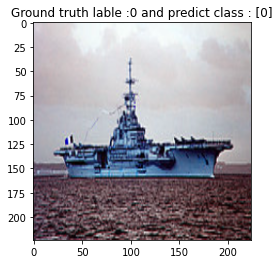

In [214]:
#test visualize
index = random.randint(0, len(x_test)-1)
prediction = clf.predict(get_featureMatrix(np.array([x_test[index]])))
plt.title(f"Ground truth lable :{y_test[index]} and predict class : {prediction}")
plt.imshow(x_test[index])
plt.show()